# Reinforcement learning: DQN from scratch

In this lab session, adapted from [here](https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter06/02_dqn_pong.py), we will acquire some familiarity with **Reinforcement Learning**. We will be using the CartPole environment provided by [OpenAI Gym](https://www.gymlibrary.ml/), which addresses the task of balancing a pole on a moving cart controlled by our agent.

<img src="https://drive.google.com/uc?export=view&id=1CZXbxmOgrdElhevO3f0QAHRbHvsfrCIy" width="500"></br>

## Anatomy of a Gym Environment

OpenAI Gym environments are a convenient way to represent the setting in which agents operate. Environments can be seen as step-by-step simulators of a certain task: we can take *observations* of the environment, and make an environment evolve by specifying an *action* for each step. Each time the environment evolves, a *reward* is generated. The typical interaction pattern consists in starting from the current observation, selecting an action to perform and producing the next observation by calling the environment `step(action)` function, which returns the next `observation`, the obtained `reward` and a `done` flag representing whether the simulation has ended and extra `metadata`.

<img src="https://drive.google.com/uc?export=view&id=1Bygq88hdhn2dPJpUufC4n0Gg4A_zpMvp" width="300"></br>

Observations can be in any form: RGB images, emulators RAM images, text or other task-specific values. In the same way, possible actions can be varied. They range from single integers to arrays of continuous values.

## The CartPole Environment

For our experiments we will use the [CartPole environment](https://www.gymlibrary.ml/environments/classic_control/cart_pole/), a 2D physical simulator which models the task of balancing a pole on a moving cart controlled by the actions.
Observations consist of 4 real values specifying `[position of cart, velocity of cart, angle of pole, rotation rate of pole]`. The action space is discrete, and consists of 2 actions: apply a force to the cart in the left direction and apply a force to the right.
For each step in which the pole is successfully balanced and the cart does not go too far from the center, the environment gives a reward of 1, otherwise the simulation is terminated.

## DQN Theory

[DQNs](https://arxiv.org/abs/1312.5602) are powerful models which became a milestone in RL. The main idea of DQNs is to use neural networks as estimators for the Q-value function of a state, and to train it following the Bellman equation for Q-values. More precisely, the Bellman equation defines the value function $V$. 

$V(s) = r(s) + \gamma \max_a \sum_{s'} P(s'|s,a)V(s')$

The same equation can be expressed in Q-value form, avoiding the maximization over $a$

$Q(s,a) = \\ = r(s) + \gamma \sum_{s'} P(s'|s,a)V(s') =\\= r(s) + \gamma \sum_{s'} P(s'|s,a)\max_{a'} Q(s',a')$

since

$V(s) = \max_a Q(s,a)$

This equation can be seen as an expectation over the probability distribution $P(s'|s,a)$ of the reward plus the discounted value of the next state

$Q(s,a) = \mathbb{E}_{s' \sim P(s'|s,a)} [r(s) + \gamma \max_{a'} Q(s',a')]$

### Training

For training, we assume two networks estimating Q-values are available: $Q_{actor}$ and $Q_{target}$. 

First, we initialize our environment and we create an *Experience Replay Buffer* which will hold a number of state transitions sampled from the environment in the form of tuples $(s, a, r, s', done)$. At each training step, we use the actor network $Q_{actor}$ to sample an action and gather a new transition to insert into the experience replay buffer. We then proceed to update the network weights. We call

$y(s,a) = r(s) + \gamma \max_{a'} Q_{target}(s',a')$

Note how we replaced the expectation in the $Q(s,a)$ equation with a sampling operation to get an estimate $y(s,a)$ for the Q-value $Q(s,a)$ from the target network. We perform sampling using our experience replay buffer.

Intuitively, we would like $Q_{actor}$ to predict Q-values that are consistent with the predictions of $Q_{target}$ so we pose

$L = [y(s,a) - Q_{actor}(s,a)]^2$

and optimize the loss with respect to the weights of $Q_{actor}$. Note how the sampled rewards $r(s)$ contribute to improve the precision of the estimate for $Q(s,a)$ by integrating knowledge sampled from the environment. $Q_{actor}$ progressively produces better Q-value estimates, so at regular intervals we copy the weights of $Q_{actor}$ to $Q_{target}$. Copying is not performed at every training step because frequent updates to $Q_{target}$ would cause abrupt changes in the training objective, leading to training instability.


## Dependencies from visualization

In [ ]:
!apt-get install -y xvfb python-opengl
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

As usual, we start by importing the necessary libraries

In [ ]:
import time
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import gym
import gym.spaces

from torch.utils.tensorboard import SummaryWriter

## DQN architecture
Since we work with low-dimensional vectors, we will be employing a multi-layer perceptron for our network. Note that, if we were working with images, a CNN-based architecture would be much more suitable.

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_features, n_actions, features=24):
        super(DQN, self).__init__()

        # multi layer perceptron
        self.mlp = nn.Sequential(
            nn.Linear(input_features, features),
            nn.ReLU(),
            nn.Linear(features, features * 2),
            nn.ReLU(),
            nn.Linear(features * 2, features * 4),
            nn.ReLU(),
            nn.Linear(features * 4, features * 2),
            nn.ReLU(),
            nn.Linear(features * 2, features),
            nn.ReLU(),
            nn.Linear(features, n_actions)
        )

    def forward(self, x):
        return self.mlp(x)

## Experience Replay Buffer

We implement our experience replay buffer as a deque (double end queue). In particular, we implement a sampling operation that selects experience transitions with uniform probability.

In [ ]:
# create a subclass of Tuple with named attributes representing experience
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceBuffer:
    def __init__(self, capacity):

        # represent the buffer as a deque
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):

        # add the current experience to the buffer
        self.buffer.append(experience)

    def sample(self, batch_size):

        # sample an index for each element in the batch
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)

        # extract experience entries for each element in the batch
        # each value returned by zip is a list of length batch_size
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        
        # return results as numpy arrays
        return np.array(states), \
               np.array(actions), \
               np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), \
               np.array(next_states)

## Agent

For convenience, we create an Agent class which manages the interaction with the environment, and populates the experience buffer. When a new experience is requested, the agent uses the network to sample the action with highest Q-value, and performs a step in the environment following that action. The resulting transition is stored in the replay buffer.

A common practice is to sample, with probability $\epsilon$, a random action instead of the one with highest Q-value. This helps the agent in increasing the exploration of the environment. $\epsilon$ starts from 1 and is linearly annealed during training.

In [ ]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer

        self._reset()

    def _reset(self):
        
        # restarts the environment and reset the accumulated reward
        self.state = self.env.reset().astype(np.float32)
        self.total_reward = 0.0

    def play_step(self, net, epsilon=0.0, device="cpu"):

        # no need to create a computational graph when gathering experience
        with torch.no_grad():

            # will contain the total reward for the episode if the episode ends
            # or None otherwise
            done_reward = None

            # sample the action randomly with probability epsilon
            if np.random.random() < epsilon:
                action = self.env.action_space.sample()

            # otherwise, select action based on qvalues
            else:

                # creates a batch made of a single state
                # state_a = np.array([self.state], copy=False)
                state_tensor = torch.tensor(self.state).unsqueeze(0).to(device)

                # get qvalues and select the index of the maximum
                q_values = net(state_tensor)
                _, selected_action = torch.max(q_values, dim=1)
                action = int(selected_action.item())

            # perform a step in the environment
            new_state, reward, is_done, _ = self.env.step(action)
            new_state = new_state.astype(np.float32)
            self.total_reward += reward

            # save the new experience
            exp = Experience(self.state, action, reward, is_done, new_state)
            self.exp_buffer.append(exp)

            # registers the current state
            self.state = new_state

            # Gets the current representation of the environment
            # current_rgb_image = self.env.render(mode='rgb_array')

            # if the episode is finished, reset the environment
            if is_done:
                done_reward = self.total_reward
                self._reset()

            return done_reward #, current_rgb_image

## Loss Function

We define a helper function that implements the loss $L$ for a minibatch of elements sampled from the experience buffer, using the actor and target networks to compute Q-values.

In [ ]:
def calc_loss(batch, net, target_net, device="cpu"):

    # unpack the batch
    states, actions, rewards, dones, next_states = batch

    #states_v = torch.tensor(np.array(states, copy=False)).to(device)
    #next_states_v = torch.tensor(np.array(next_states, copy=False)).to(device)

    # transform the batch elements to tensors
    states_v = torch.from_numpy(states).to(device)
    next_states_v = torch.from_numpy(next_states).to(device)
    actions_v = torch.tensor(actions).to(device)
    rewards_v = torch.tensor(rewards).to(device)
    done_mask = torch.BoolTensor(dones).to(device)

    # infer the qvalues for the states
    state_qvalues = net(states_v)

    # extract the qvalues for the action that was selected
    state_action_qvalues = state_qvalues.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():

        # compute the qvalues for the next states using the target DQN
        next_state_qvalues = target_net(next_states_v)

        # extract the maximum one
        next_state_max_qvalue = next_state_qvalues.max(dim=1)[0]

        # if the next state refers to an ended episode, it has no value
        next_state_max_qvalue[done_mask] = 0.0
        
        next_state_max_qvalue = next_state_max_qvalue.detach()

    # Computes the expected qvalue using the Bellman equation
    expected_state_action_qvalues = rewards_v + GAMMA * next_state_max_qvalue

    # Penalizes the DQN for inferring a qvalue different from the one
    # computed with the target DQN using the Bellman equation
    return nn.MSELoss()(state_action_qvalues, expected_state_action_qvalues)

## Train Loop

Let's put everything together to train our network

In [ ]:
DEFAULT_ENV_NAME = "CartPole-v1"

# we terminate training if the model on average balances the pole
# for at least 195 steps
MEAN_REWARD_BOUND = 195

# discount factor
GAMMA = 0.99

BATCH_SIZE = 32

# size of the replay buffer
REPLAY_SIZE = 10000

# warmup frames for the replay buffer
REPLAY_START_SIZE = 10000

LEARNING_RATE = 1e-4

# frequency for transferring weights from the actor DQN to the target DQN
SYNC_TARGET_FRAMES = 1000

# epsilon
EPSILON_DECAY_LAST_FRAME = 15000
EPSILON_START = 1.0
EPSILON_FINAL = 0.01

def train(net, target_net, env, buffer, agent, device, writer):

    # epsilon starts from the initial value and is then annealed
    epsilon = EPSILON_START

    # instantiate the optimizer. Note that target_net is not optimized
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    total_rewards = []
    frame_idx = 0

    # frame idx and time at which the last episode ended
    ts_frame = 0
    ts = time.time()
    best_m_reward = None

    while True:
        frame_idx += 1

        # compute the current epsilon with linear annealing
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / EPSILON_DECAY_LAST_FRAME)

        # perform a step in the environment to gather experience
        # reward, rbg_image = agent.play_step(net, epsilon, device=device)
        reward = agent.play_step(net, epsilon, device=device)

        # if the current episode has ended
        if reward is not None:

            # register the current total reward
            total_rewards.append(reward)

            # compute training speed
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()

            # compute the mean reward over the last 100 episodes
            m_reward = np.mean(total_rewards[-100:])
            print("%d: done %d games, reward %.3f, eps %.2f, speed %.2f f/s" % (
                frame_idx, len(total_rewards), m_reward, epsilon, speed
            ))

            # log values
            writer.add_scalar("epsilon", epsilon, frame_idx)
            writer.add_scalar("speed", speed, frame_idx)
            writer.add_scalar("reward_100", m_reward, frame_idx)
            writer.add_scalar("reward", reward, frame_idx)

            # update best rewards
            if best_m_reward is None or best_m_reward < m_reward:
                #torch.save(net.state_dict(), args.env + "-best_%.0f.dat" % m_reward)
                if best_m_reward is not None:
                    print("Best reward updated %.3f -> %.3f" % (best_m_reward, m_reward))

                best_m_reward = m_reward
            
            # stop training when a certain reward is achieved
            if m_reward > MEAN_REWARD_BOUND:
                print("Solved in %d frames!" % frame_idx)
                break

        # continue to collect experience until the warmup finishes
        if len(buffer) < REPLAY_START_SIZE:
            continue

        # at regular intervals load the weights of the actor DQN into the target DQN
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            target_net.load_state_dict(net.state_dict())

        # perform an optimization step
        optimizer.zero_grad()
        batch = buffer.sample(BATCH_SIZE)
        loss_t = calc_loss(batch, net, target_net, device=device)
        loss_t.backward()
        optimizer.step()

## Visualization (works offline)

For visualization purposes, we create a helper function that uses a DQN to play an episode in the environment, saving the observations as a video that is logged to TensorBoard.

In [ ]:
def save_episode(net, env, agent, device, writer):
    
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    # reset the environment
    agent._reset()
    all_frames = []

    reward = None

    # play an episode
    while reward is None:

        reward, rgb_image = agent.play_step(net, epsilon=0.0, device=device)

        # change fromat from (H, W, C) to (C, H, W) and saves the image
        rgb_image = torch.from_numpy(np.copy(rgb_image)).permute(2, 0, 1)
        all_frames.append(rgb_image)

    # video must be put into (batch, time, C, H, W) format to be saved
    video = torch.stack(all_frames, dim=0).unsqueeze(0)
    # save the video
    writer.add_video("sample_episode", video, global_step=0, fps=10)

Let's train!

In [ ]:
def main():

    device = torch.device("cuda:0")

    # build the environment
    env = gym.make(DEFAULT_ENV_NAME)

    # create actor and target DQN models
    net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)

    # initialize the logger
    writer = SummaryWriter(log_dir="runs")
    print(net)

    # instantiate the experience buffer and the agent that collects experience
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)

    # train the network
    train(net, target_net, env, buffer, agent, device, writer)
    
    # save a sample episode
    # save_episode(net, env, agent, device, writer)

    writer.close()


In [ ]:
!rm -r runs

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
main()

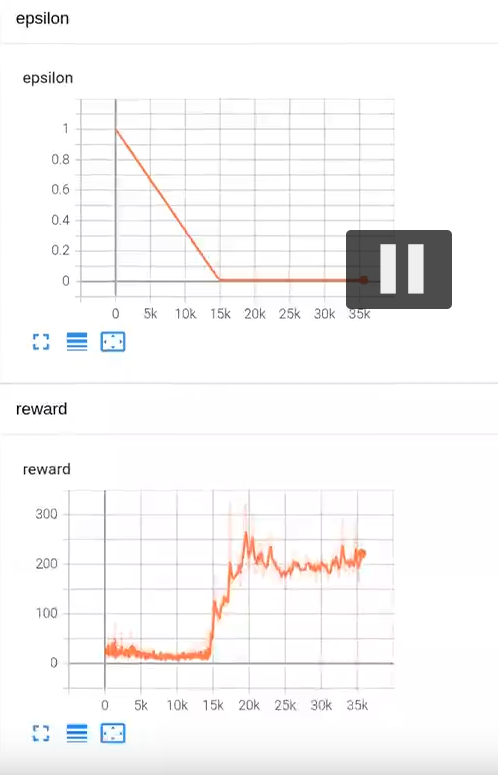